In [5]:
import pandas as pd
from numpy import nan
import numpy as np
import re
from langdetect import detect
import pycountry

In [2]:
def openData():
    """
    Opens the csv with the data and cleans the dataset and returns a dataframe.
    """
    # Sort data in descending order by page visibility. This ensures duplicates without page followers are dropped.
    data = pd.read_csv("data/output_facebook_data.csv").sort_values('visibility', ascending=False)
    data = data.drop_duplicates(['altmetric_id'], keep='first')
    
    data['fb_wall_urls'] = data['fb_wall_urls'].apply(lambda x: eval(x))
    
    def func(inp):
        """
        Used as a 'lambda' function for the mapping functions below.
        """
        if inp is nan:
            return inp
        try:
            res = eval(inp)
        except:
            res = [inp]
        return res
    
    data['subjects'] = data['subjects'].map(func)
    data['scopus_subjects'] = data['scopus_subjects'].map(func)
    data['publisher_subjects'] = data['publisher_subjects'].map(func)
    
    data['fb_wall_count'] = data['fb_wall_count'].astype(int)
    
    return data


def makePageData(df):
    """
    Takes the dataframe of articles and makes a new dataset of pages.
    """
    df['fb_wall_count'] = df['fb_wall_count'].astype(int)
    res_dict = dict()
    
    for i in df.index.values:
        for j in range(len(df.loc[i, 'fb_wall_urls'])):
            try:
                page_id = re.search(r'fbid=(.+?)&', df['fb_wall_urls'][i][j]['link']).group(1)
            except:
                page_id = re.search(r'/(.+?)/', df['fb_wall_urls'][i][j]['link']).group(1)
            if page_id in res_dict:
                res_dict[page_id]['num_articles'] += 1
                res_dict[page_id]['articles'].append(df.loc[i, 'title'])
            else:
                res_dict[page_id] = {'page_id': page_id, 
                                     'num_articles': 1, 
                                     'articles': [df.loc[i, 'title']]}
    
    return pd.DataFrame(res_dict).transpose()


def allSubjects(df):
    """
    Makes a new column that is a list of all subjects associated with an article.
    """
    res = []
    
    for i in df.index.values:
        subj = []
        
        if df.loc[i, 'subjects'] is not nan:
            subj += df.loc[i, 'subjects']
        if df.loc[i, 'scopus_subjects'] is not nan:
            subj += df.loc[i, 'scopus_subjects']
        if df.loc[i, 'publisher_subjects'] is not nan:
            subj += df.loc[i, 'publisher_subjects']
        
        res.append(subj)
    return res
        

In [3]:
data = openData()

df = data[data['fb_wall_count'] > 5].sort_values(by='fb_wall_count', ascending=False)

df['all_subjects'] = allSubjects(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 44655 to 4530
Data columns (total 18 columns):
altmetric_id          895 non-null float64
title                 893 non-null object
subjects              527 non-null object
abstract              647 non-null object
pubdate               895 non-null object
fb_wall_count         895 non-null int64
scopus_subjects       583 non-null object
publisher_subjects    566 non-null object
fb_wall_urls          895 non-null object
shares                895 non-null int64
visibility            895 non-null int64
total_like            895 non-null int64
total_love            895 non-null int64
total_wow             895 non-null int64
total_haha            895 non-null int64
total_sad             895 non-null int64
total_angry           895 non-null int64
all_subjects          895 non-null object
dtypes: float64(1), int64(9), object(8)
memory usage: 172.9+ KB


In [12]:
df.iloc[0]['fb_wall_urls']

[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1082225441933120&id=173512219471118',
  'like': 9,
  'love': 0,
  'wow': 0,
  'haha': 0,
  'sad': 0,
  'angry': 2,
  'page_likes': nan,
  'page_followers': nan,
  'message': 'I bambini vaccinati muoiono cinque volte di più dei bambini non vaccinati.\n\nI bambini della Guinea-Bissau vaccinati con il trivalente difterite-tetano-pertosse e con l’antipolio orale muoiono 5 (cinque) volte di più rispetto ai coetanei non vaccinati. \nE\' passato in sordina lo studio statistico indipendente datato 01 febbraio 2017 dal titolo: L\'introduzione del vaccino Difterite-Tetano-Pertosse e del vaccino orale antipolio tra i giovani neonati in una comunità africana urbana: Esperimento naturale (The Introduction of Diphtheria-Tetanus-Pertussis and Oral Polio Vaccine Among Young Infants in an Urban African Community: A Natural Experiment). \n\nDei ricercatori indipendenti danesi hanno esaminato l\'introduzione dei vaccino Difterite-Tetano-Pertoss

In [17]:
res = {'unknown': 0}

for i in df.index.values:
    for d in df.loc[i, 'fb_wall_urls']:
        try:
            lang = detect(d['message'])
            if lang in res:
                res[lang] += 1
            else:
                res[lang] = 1
#             if lang=='ar':
#                 print(d['message'])
        except:
            res['unknown'] += 1

"اللقاحات أنقذت البشرية!" وتسببت بارتفاع مخاطر الوفاة للرضع المطعمين ١٠ أضعاف غير المطعمين. 
https://t.co/QPTPQW17SZ https://t.co/wWgGXhbKWb
"اللقاحات أنقذت البشرية"!!!
لكن لقاح DPT رفع مخاطر الوفاة للرضع المطعمين 10 أضعاف غير المطعمين
https://t.co/QPTPQVJx1r https://t.co/LZ8SCC18pR
١٧ نوفمبر ٢٠١٧        

السادة رئيس وأعضاء مجلس الأمة الموقر / دولة الكويت

الموضوع: دعوة لتعديل مواد التطعيم في قانون حقوق الطفل رقم ٢١ لعام ٢٠١٥

 السلام عليكم ورحمة الله وبركاته. أما بعد،

نتوجه إليكم بهذه الرسالة المفتوحة، لنقدم اعتراضنا على البنود التالية الواردة في قانون حقوق الطفل (١) وندعوكم لتعديلها :

 ⚫مادة رقم ١٨ حول تطعيم الطفل وتحصينه؛ في النص: «يجب تطعيم الطفل بالمواعيد وتحصينه بالطعوم الواقية من الأمراض المعدية».
 ⚫ مادة رقم ٧١  بند ١؛ في النص: «الإهمال ومن أمثلته:  عدم تقديم الرعاية الصحية الوقائية للطفل (مثل التطعيمات)».
⚫ مادة  رقم ٨٣؛ في النص: «مع عدم الإخلال بأي عقوبة أشد ينص عليها قانون آخر ، يعاقب بالحبس مدة لا تزيد على ستة أشهر وغرامة لا تزيد عن ألف دينار أو بإحدى العقوبتين كل ولي أم

فتاة بعمر الثمان سنوات تنشر ورقة في مجلة علمية!

صوفيا سبنسر البالغة من العمر ثمان سنوات تنشر ورقتها الأولى في مجلة   “Discover Wildlife reports
  العلمية المختصة بالأبحاث المتعلقة بالحياة البرية. حدث ذلك على إثر قيام والدة سبنسر بمراسلة جمعية علم الحشرات الكندية وذلك قبل عام لإخبارهم أن ابنتها سبنسر تتعرض للترهيب لحبها للحشرات طالبةً منهم أن يجعلوها على اتصال مع أحد علماء الحشرات ليساعد سبنسر على اشباع فضولها وإيجاد الأجوبة لأسئلتها. الجدير بالذكر أنّ الجمعية تلقت أكثر من مئة رسالة دعم  من علماء شجعوا سبنسر على مواصلة استكشاف عالم الحشرات وذلك بعد ان تمّت مشاركة البريد الإلكتروني المرسل من والدتها على وسائل التواصل الاجتماعي.  واستكمالًا لدعمها  تمت دعوة سبنسر للمشاركة ككاتب مشارك للحديث عن قصتها وفضولها لاستكشاف عالم الحشرات ضمن اصدار خاص من  مجلة

Discover Wildlife report

المصدر: https://goo.gl/jVi7si
الورقة التي شاركت سبنسر بها: https://goo.gl/Jr2zJP
ساعات الدوام الكامل كافية ووافية
http://go.nature.com/2vB5hG7
#نيتشر #علوم #عمل
ك الكميات التى تبقى من المبيدات الحشرية لا تكون تتعد

التحليل التطوري للحمض النووي للخلايا السرطانية الدوَّارة يكشف المراحل المبكرة في تطور سرطان الرئة
http://go.nature.com/2sqR49D
#نيتشر #علوم #أبحاث
ى تعزيز قابلية انتاج مواد معينة تزيد من قوة الجهاز المناعي في حياته لاحقا . بالتأكيد الطريق لازال طويلا لمعرفة الصورة كاملة لكن هناك عدة دراسات تقول بأن الصدمة في الطفولة اضافة الى الاهتمام وحنان الأم / الأب يؤثر في التركيبة الجينية للطفل بل بعضها يقول بتأثير يمتد إلى ذرية هذا الطفل لأجيال عديدة بعده . # مشروع_العراق_الجيني https :// www . cambridge . org / core / journals / development - - psychopathology / article / epigenetic - correlates - - neonatal - contact - - humans / 9bd9799a7c6e0859b93e092ea0727a4b
هل تعتبر نفسك شخصاً بطيء المشي؟ 🚶
إذا يجب أن تسرع خطاك. 🏃🏻
المصدر: https://buff.ly/2eRTKbO
يبدوا انه ليس من المجدي تحري اعتلال الشريان  التاجي عند وجود ألم معزول لجهة القلب من القفص الصدري لتفادي الجلطة القلبية 
http://jamanetwork.com/journals/jamainternalmedicine/article-abstract/2633257?amp%3butm_source=JAMA+Intern+MedPublishAheadofPr

In [23]:
langs = pd.Series(res)

In [26]:
langs.sort_values(ascending=False)

en         6026
unknown    3377
es          284
fr          135
pt          133
it          124
de           73
ja           55
pl           50
nl           39
ca           33
ro           33
ar           27
fi           25
et           24
th           22
ko           21
ru           17
cs           16
sv           16
af           15
da           15
no           13
hu           13
cy           13
tl           12
he            9
el            9
zh-tw         8
so            6
tr            6
uk            5
vi            5
sl            4
hr            4
id            3
lt            3
sk            2
sq            2
mk            1
bn            1
bg            1
sw            1
dtype: int64

In [54]:
tot = langs.sum()
perc_langs = langs.apply(lambda x: 100*(x/tot))

In [55]:
perc_langs = pd.DataFrame(perc_langs)

In [56]:
for i in perc_langs.index.values:
    try:
        perc_langs.loc[i, 'country'] = pycountry.languages.lookup(i).name
    except:
        continue

In [58]:
perc_langs.sort_values(0, ascending=False)

,0,country
en,56.417938,English
unknown,31.616890,NaN
es,2.658927,Spanish
fr,1.263927,French
pt,1.245202,Portuguese
it,1.160940,Italian
de,0.683457,German
ja,0.514933,Japanese
pl,0.468121,Polish
nl,0.365134,Dutch


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

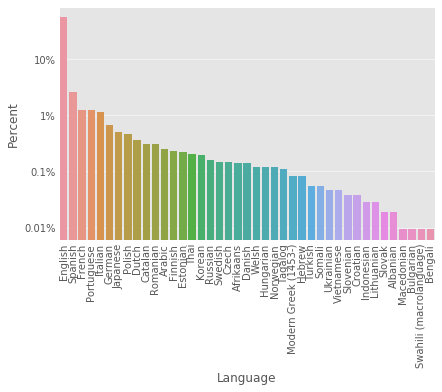

In [83]:
style.use('ggplot')

ax = sns.barplot(x='country', y=0, data=perc_langs.sort_values(0, ascending=False))
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.xlabel("Language")
plt.ylabel("Percent")

ax.set_yticklabels(['', '', '0.01%', '0.1%', '1%', '10%'])
# plt.tight_layout()

plt.savefig("languages.png", format='png', dpi=500, bbox_inches='tight', )